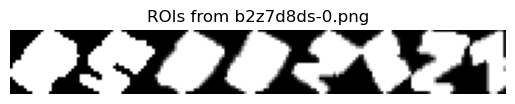

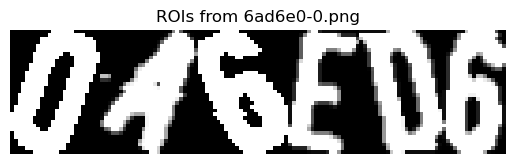

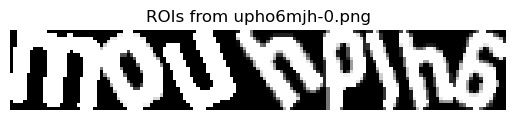

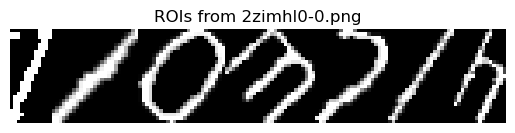

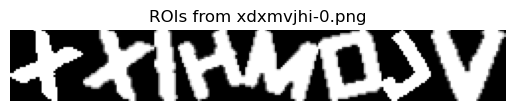

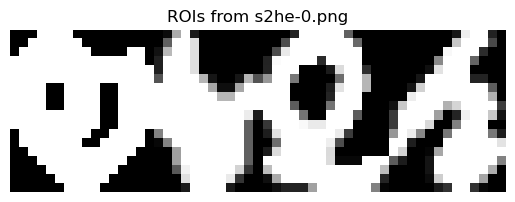

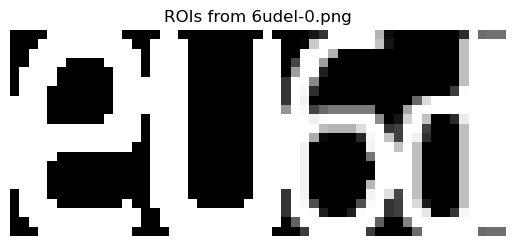

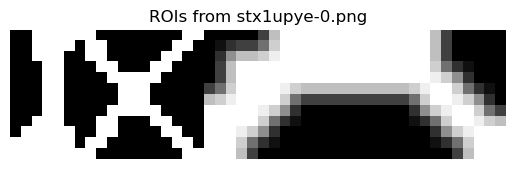

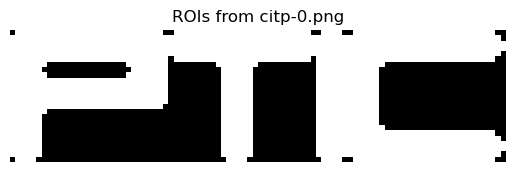

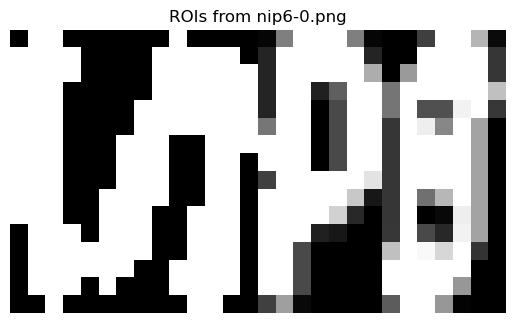

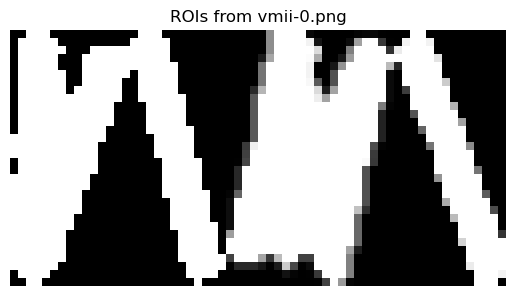

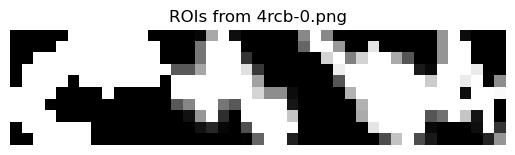

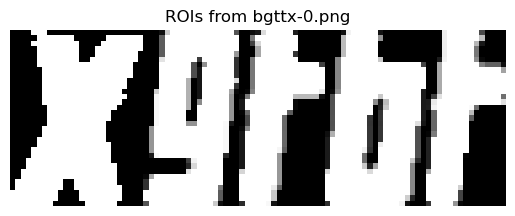

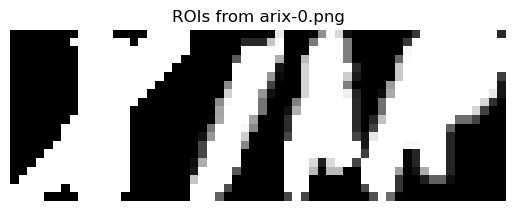

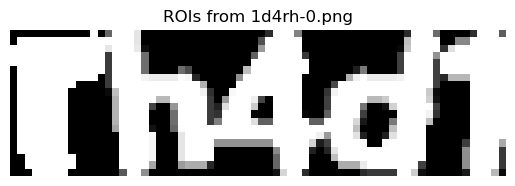

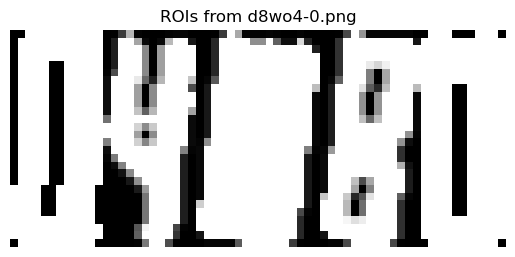

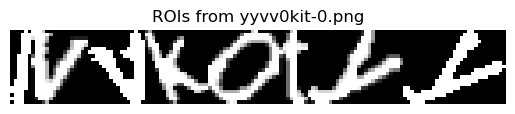

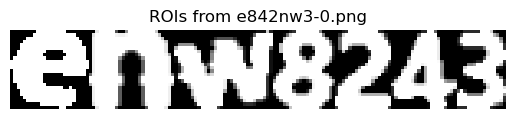

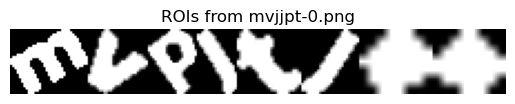

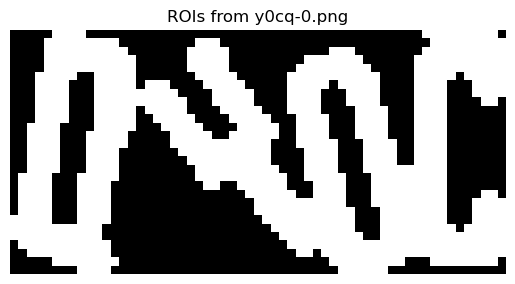

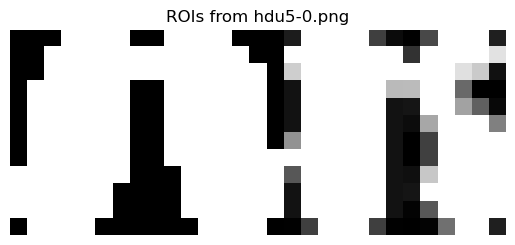

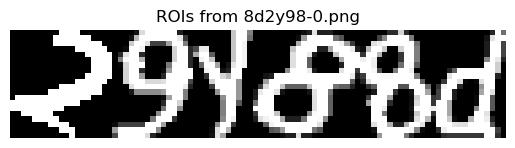

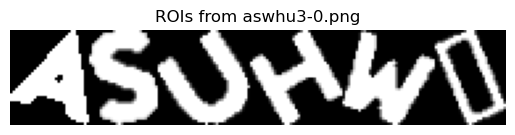

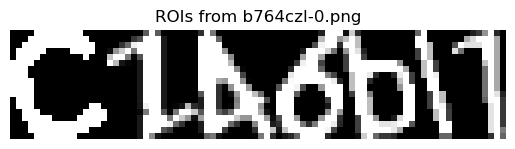

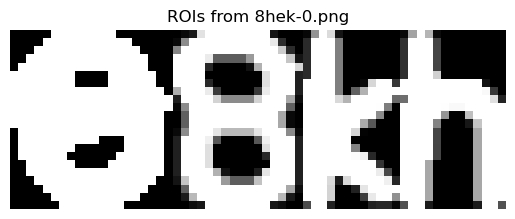

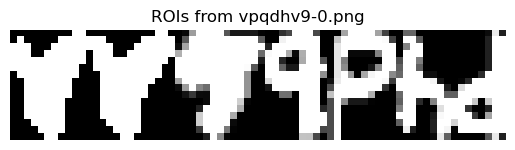

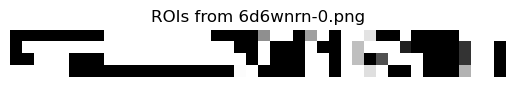

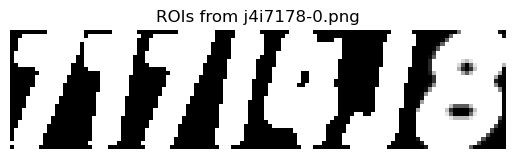

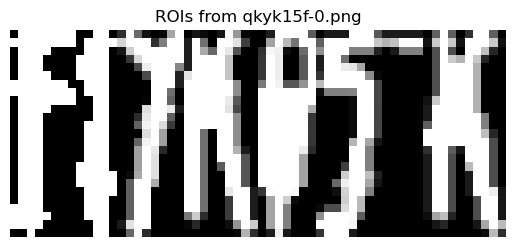

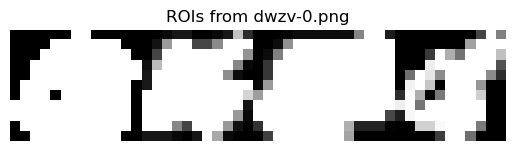

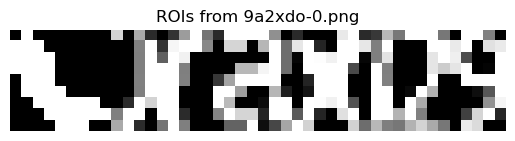

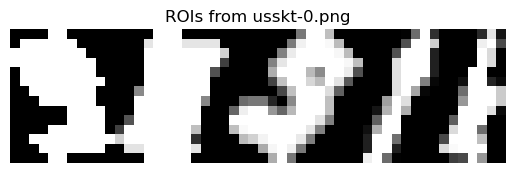

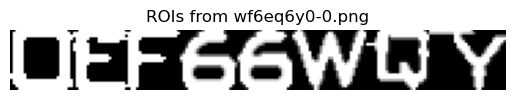

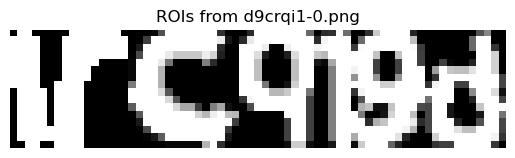

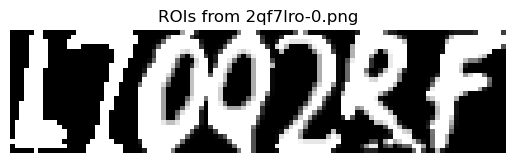

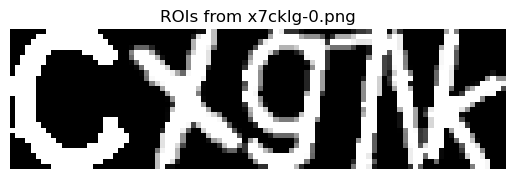

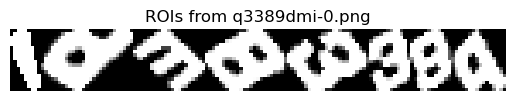

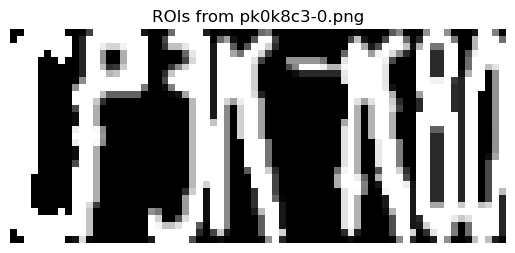

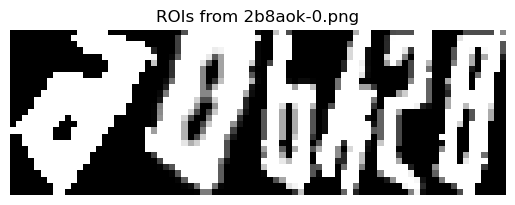

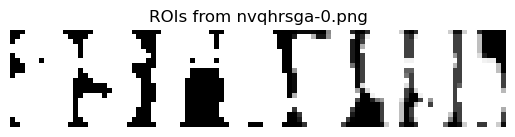

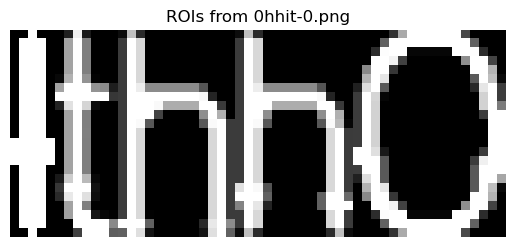

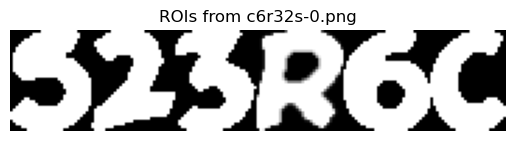

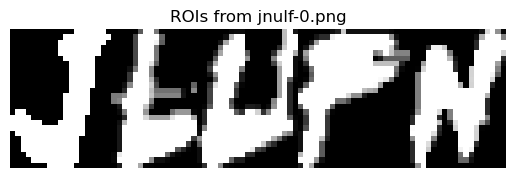

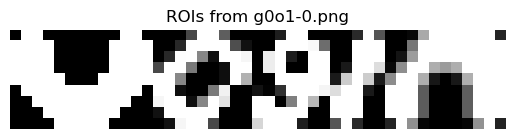

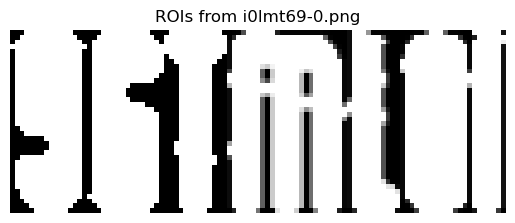

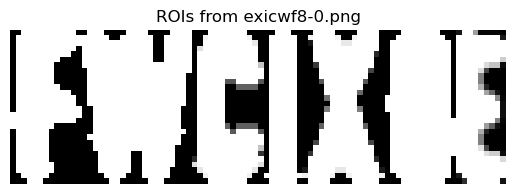

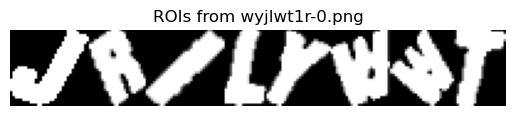

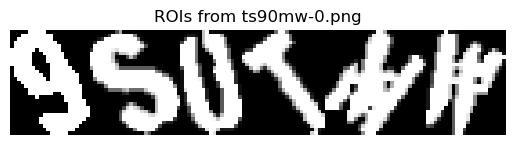

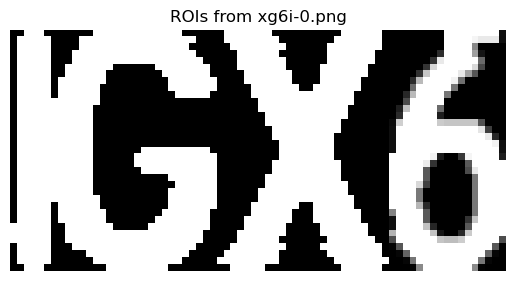

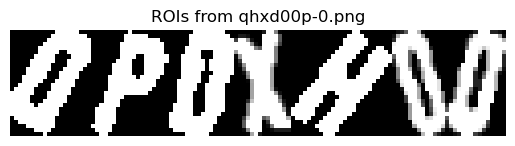

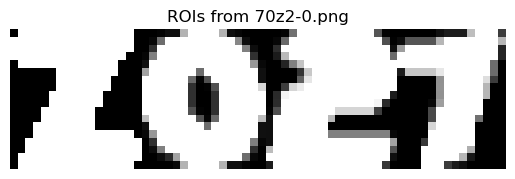

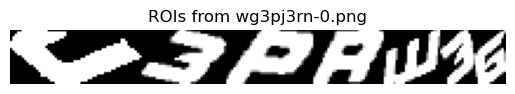

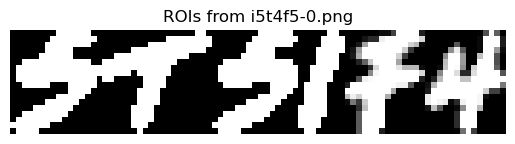

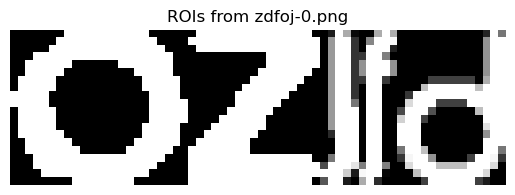

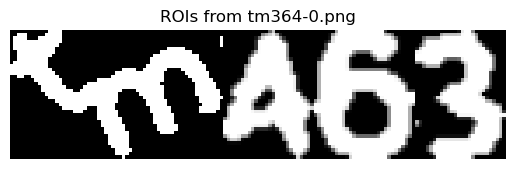

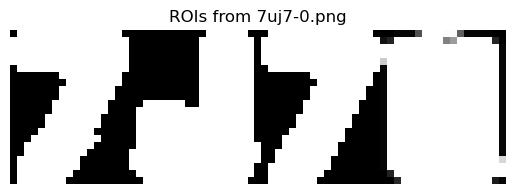

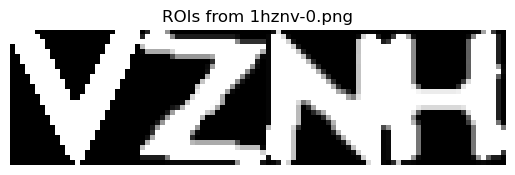

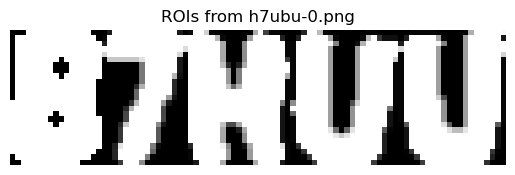

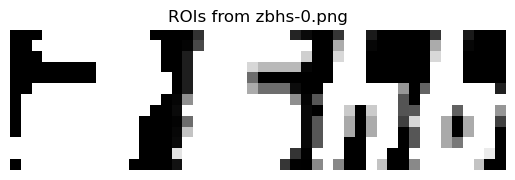

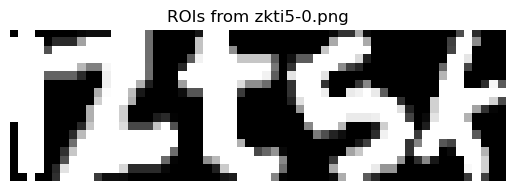

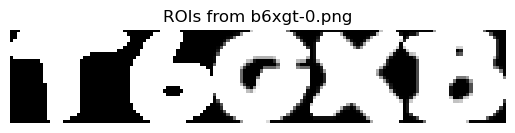

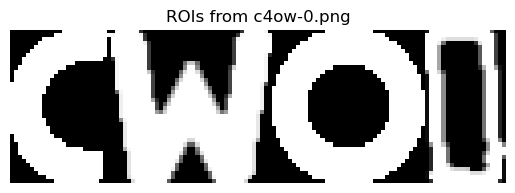

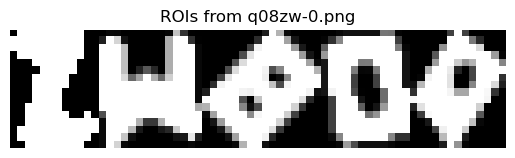

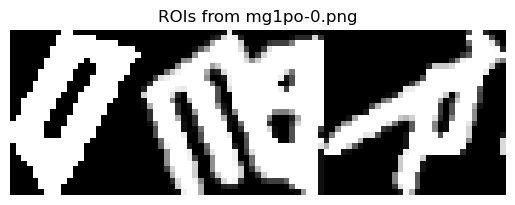

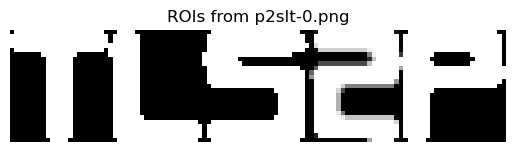

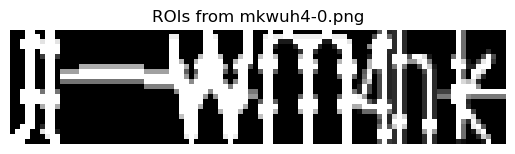

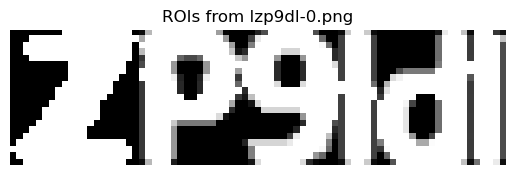

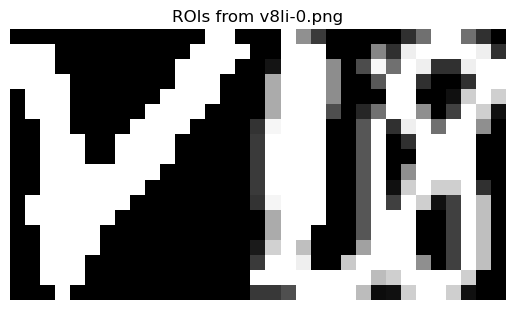

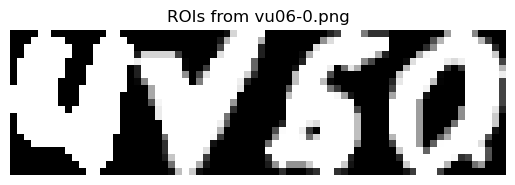

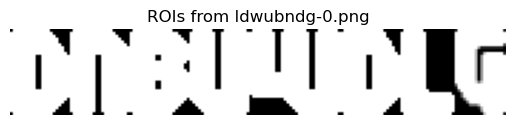

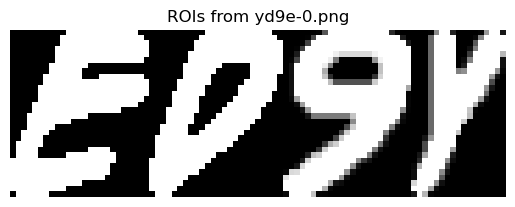

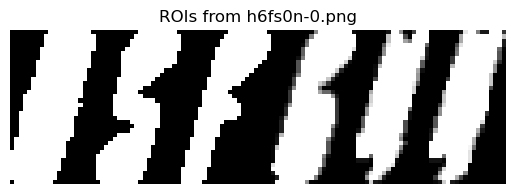

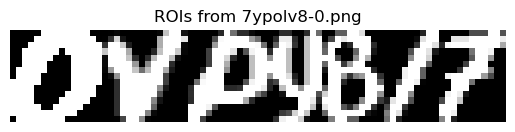

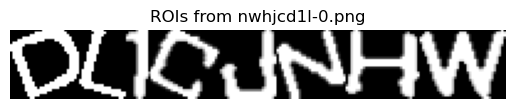

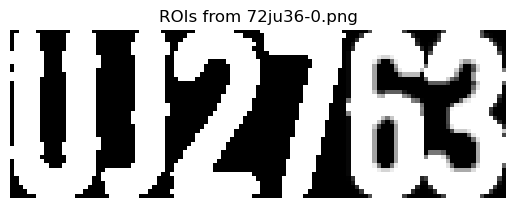

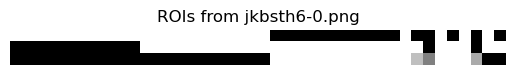

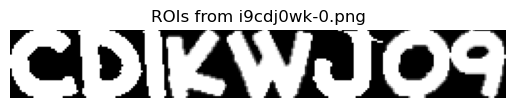

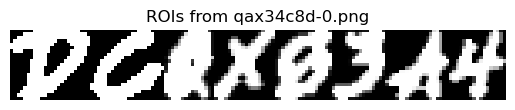

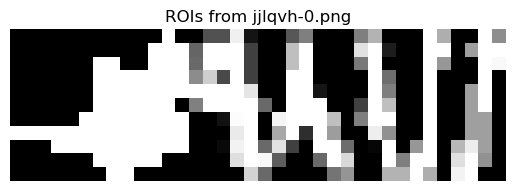

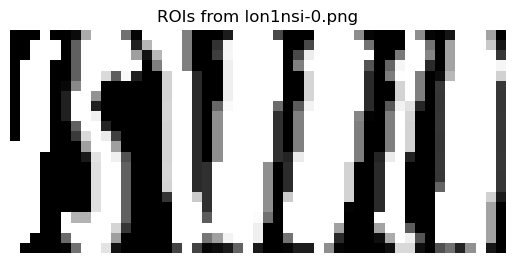

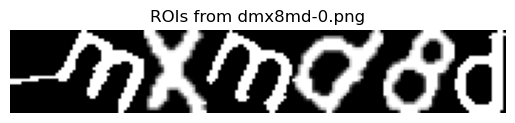

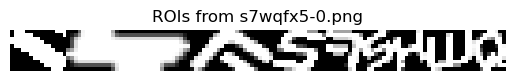

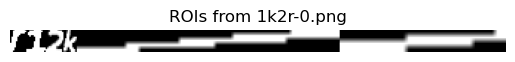

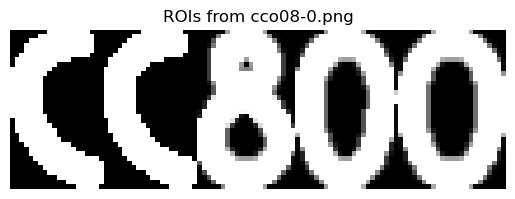

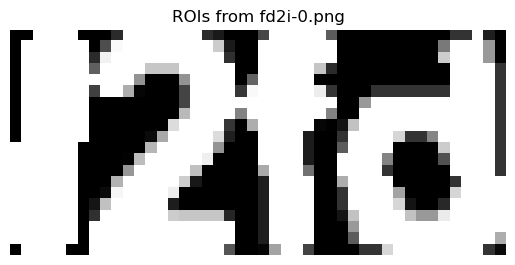

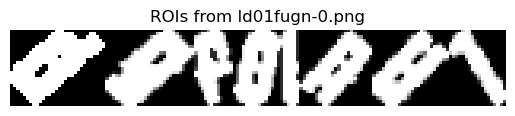

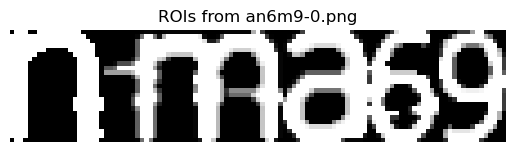

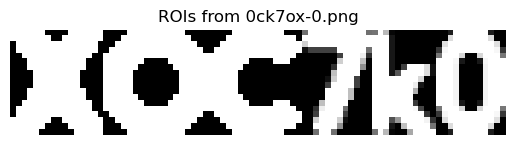

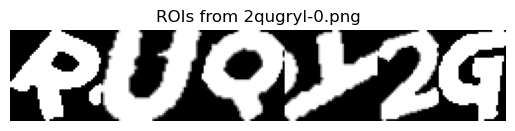

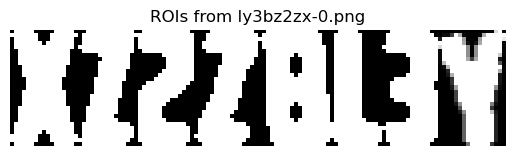

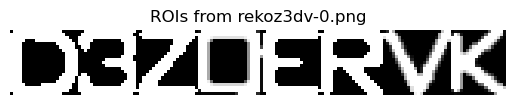

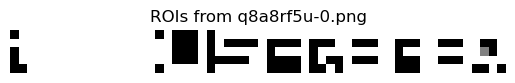

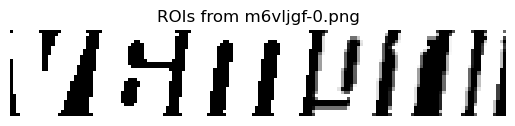

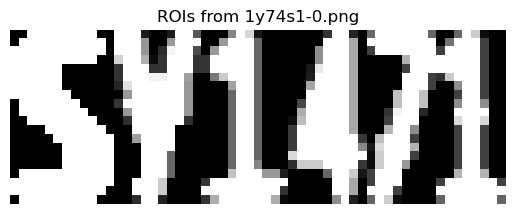

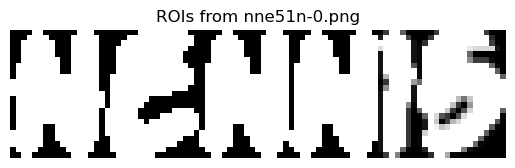

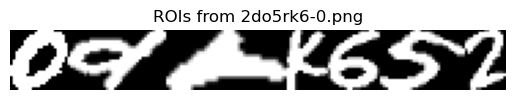

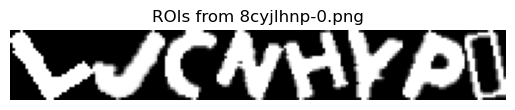

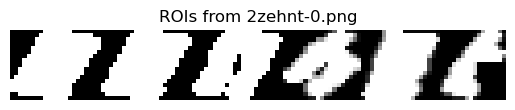

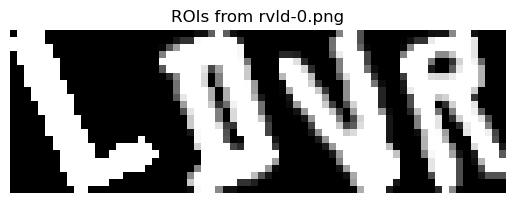

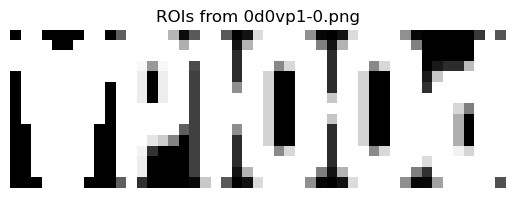

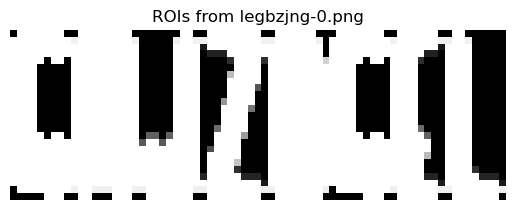

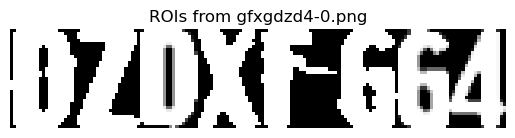

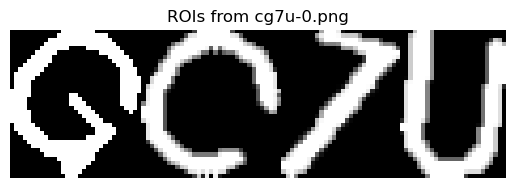

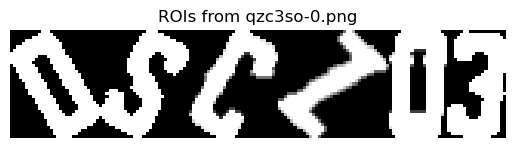

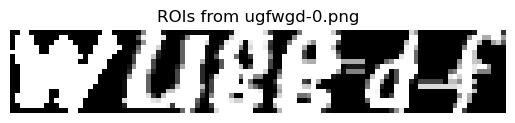

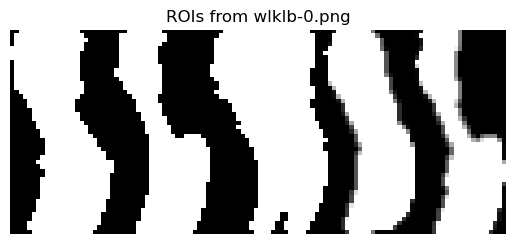

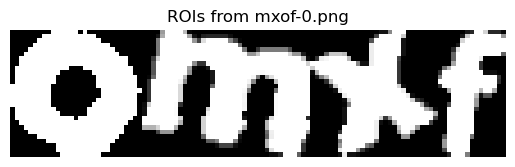

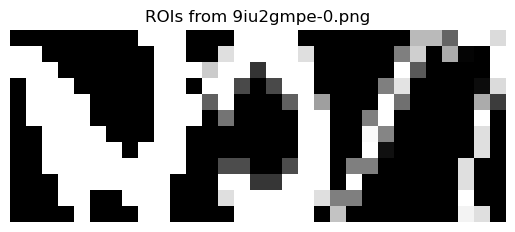

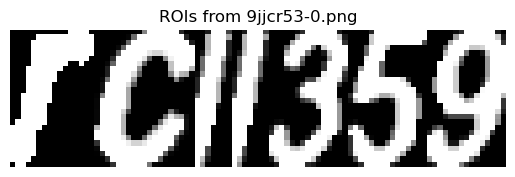

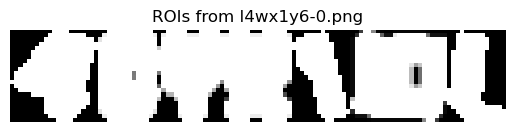

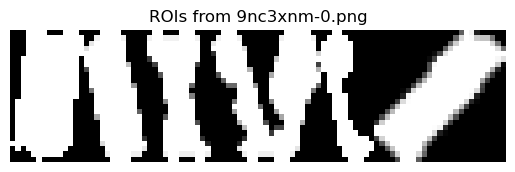

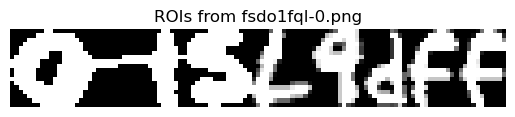

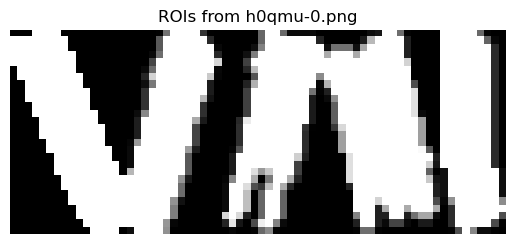

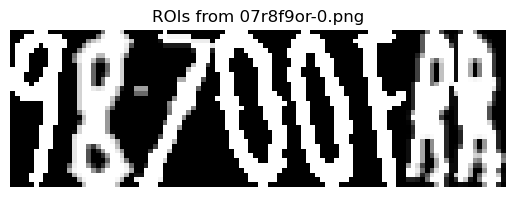

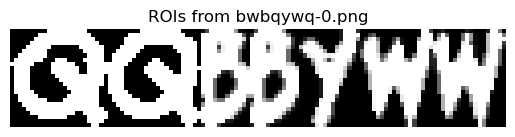

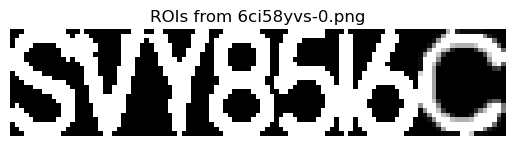

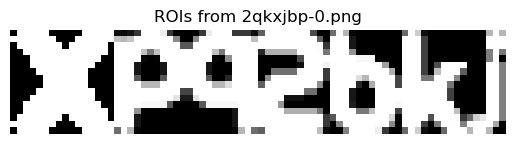

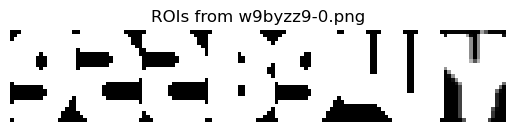

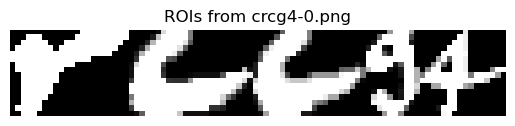

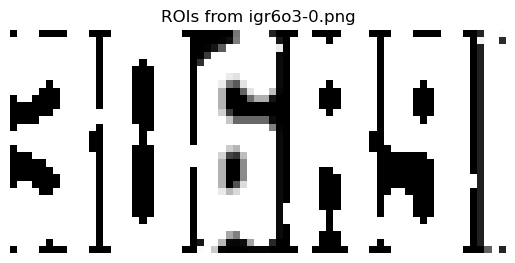

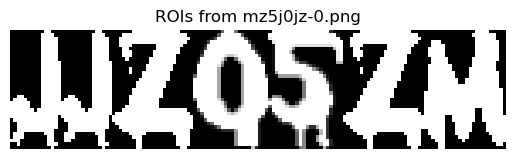

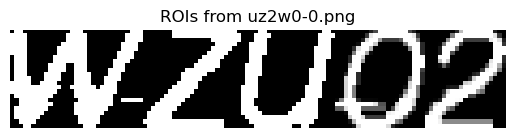

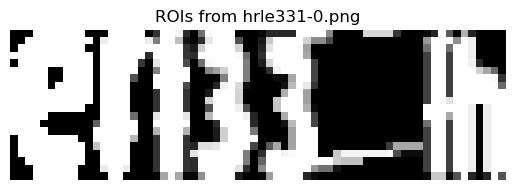

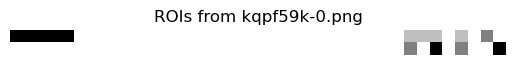

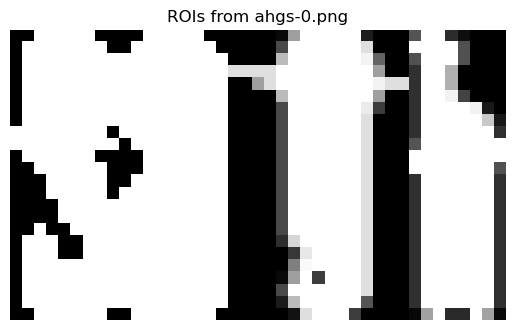

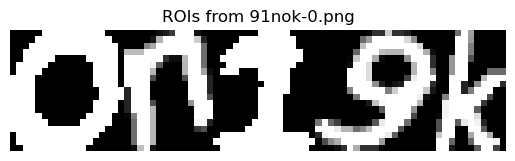

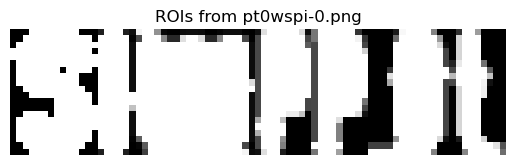

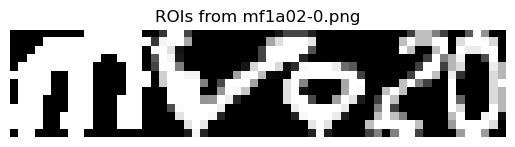

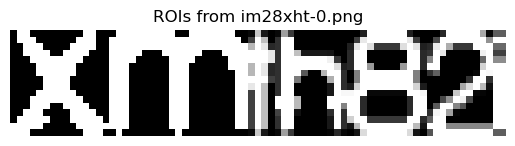

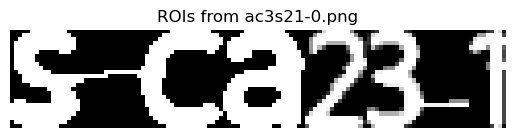

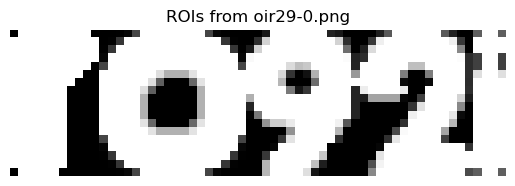

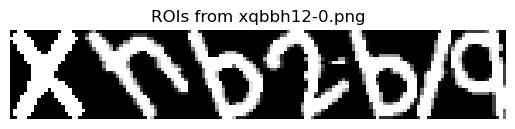

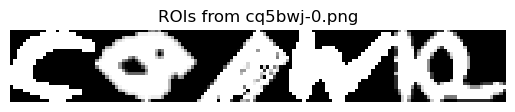

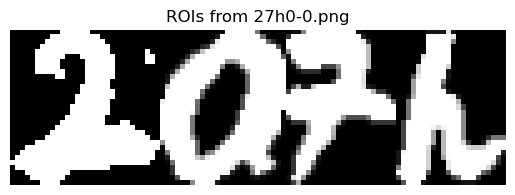

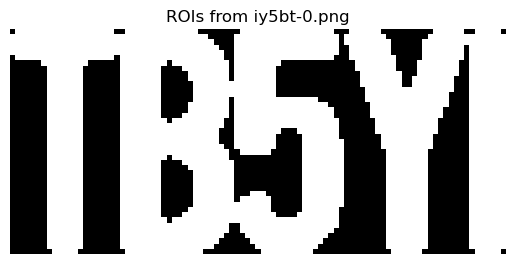

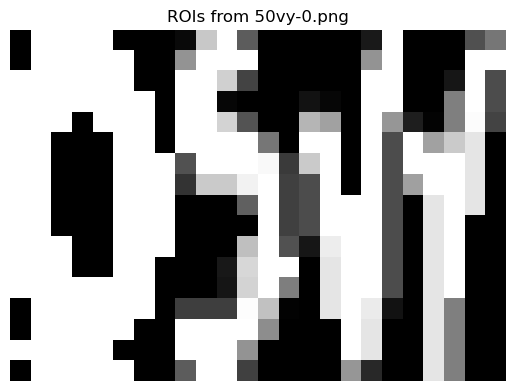

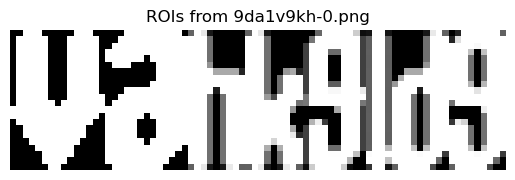

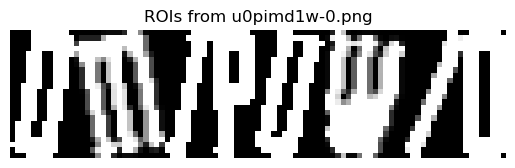

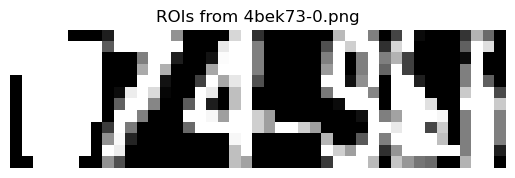

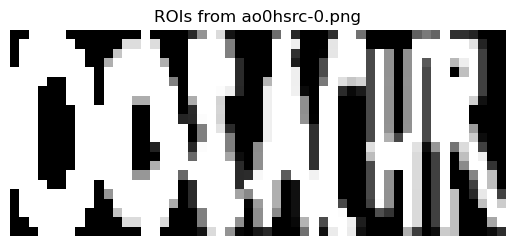

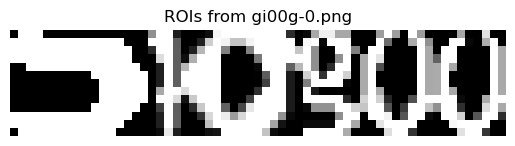

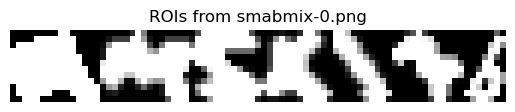

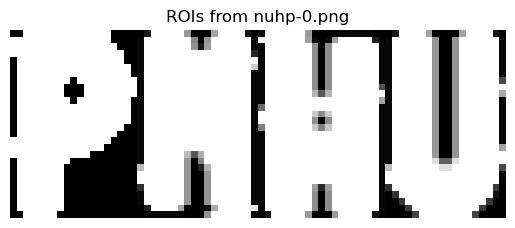

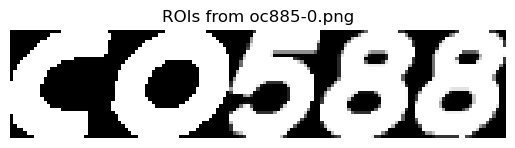

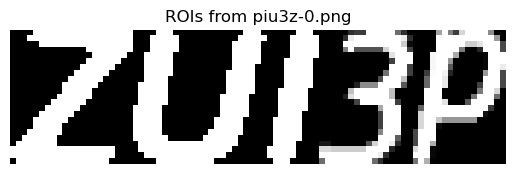

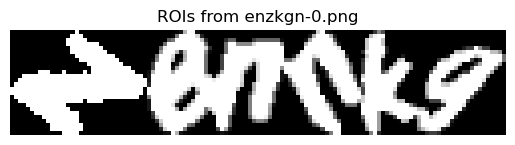

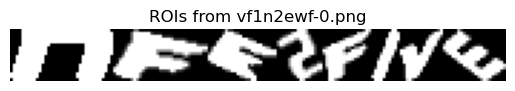

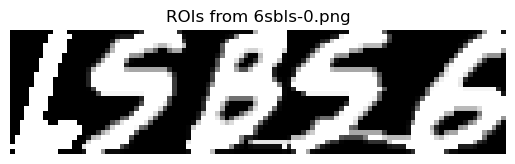

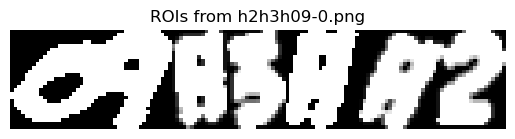

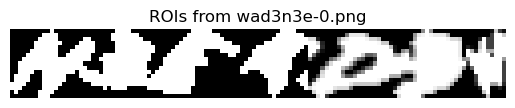

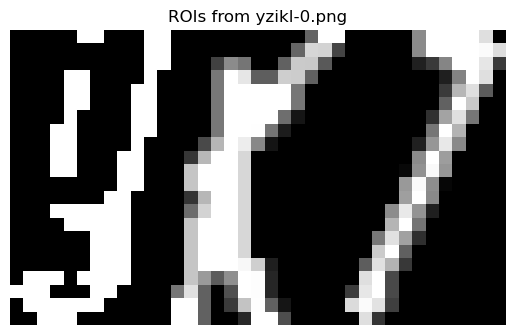

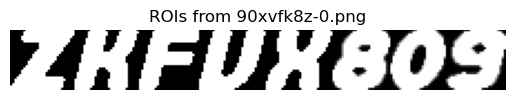

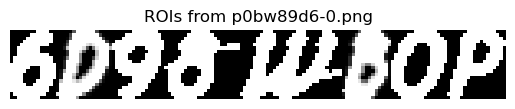

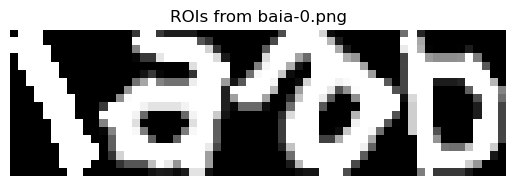

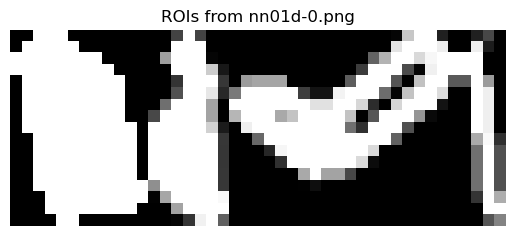

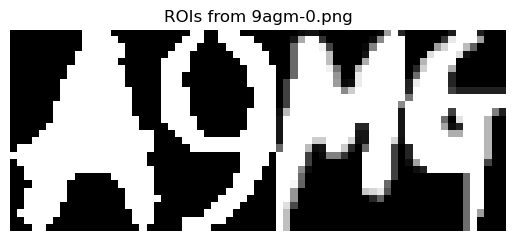

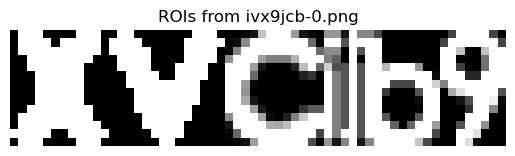

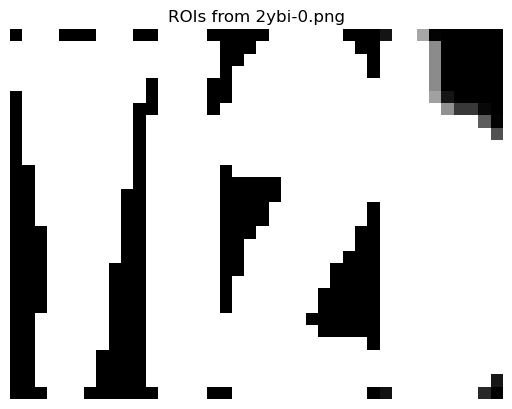

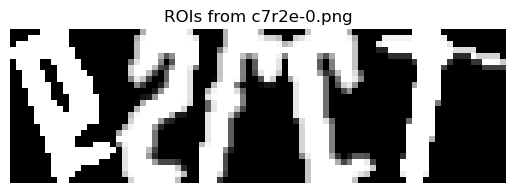

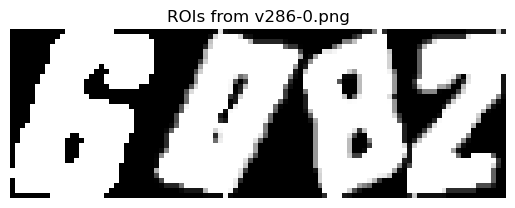

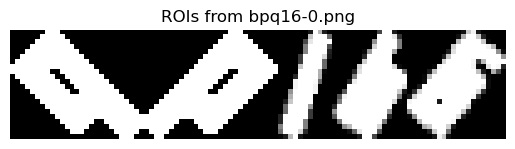

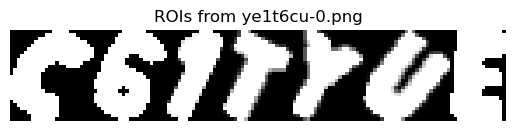

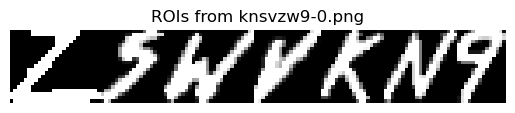

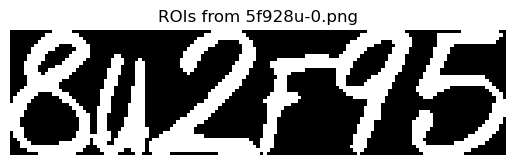

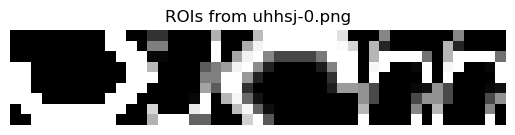

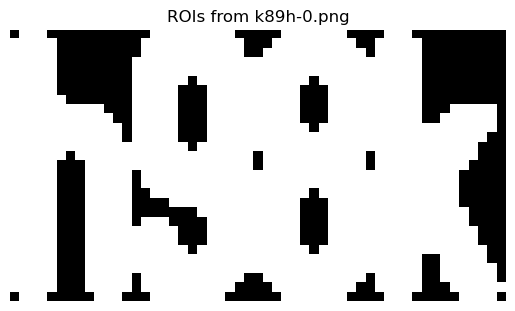

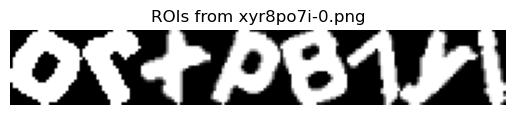

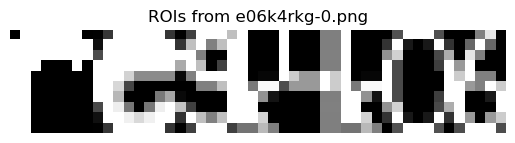

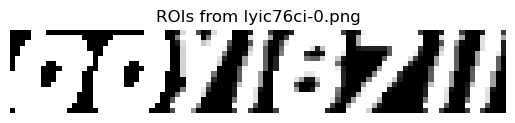

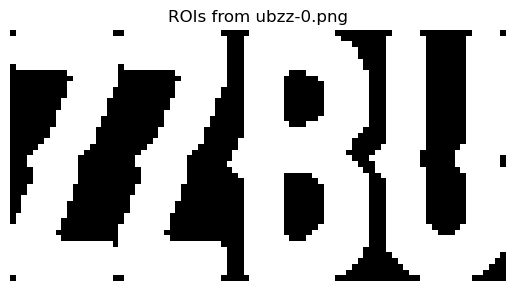

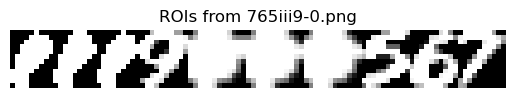

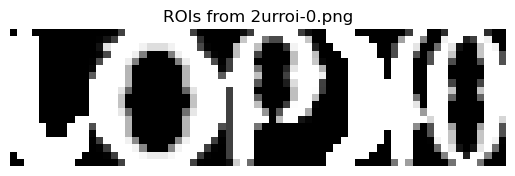

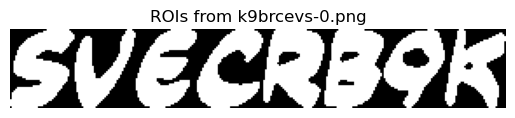

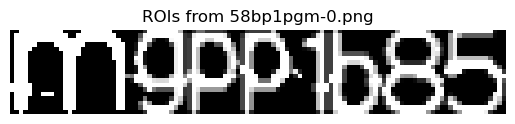

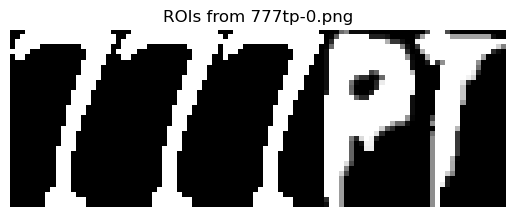

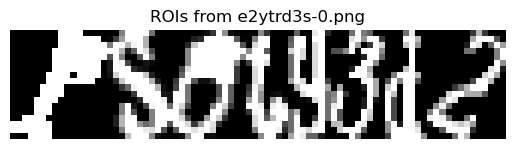

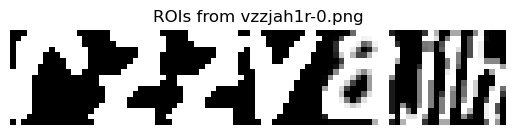

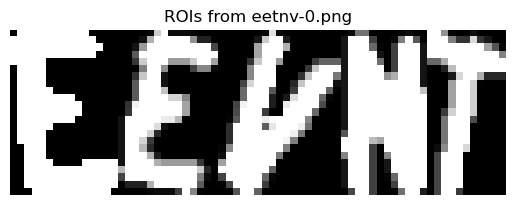

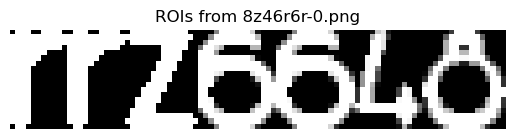

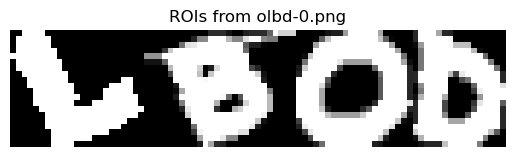

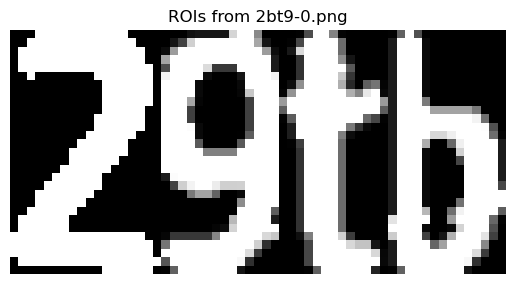

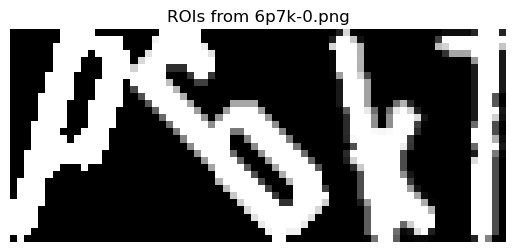

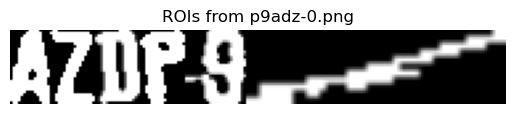

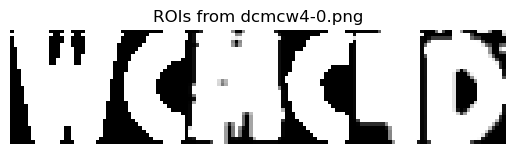

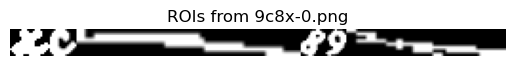

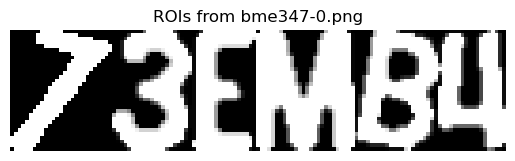

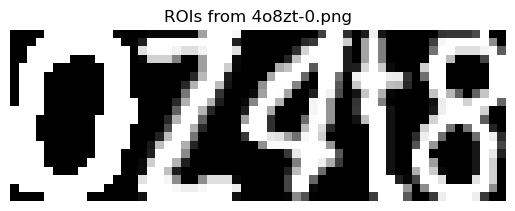

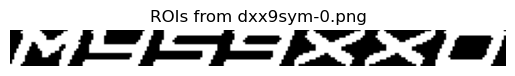

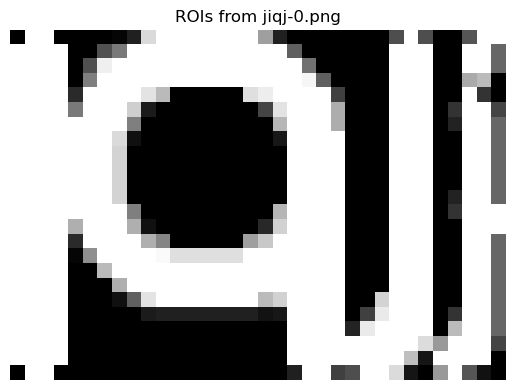

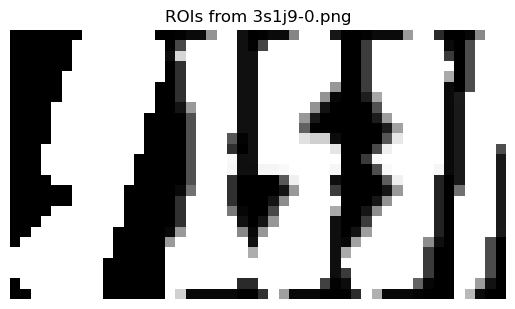

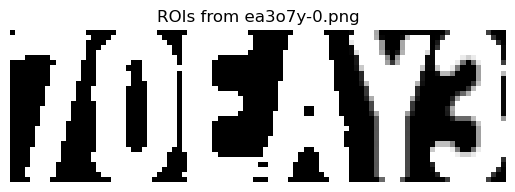

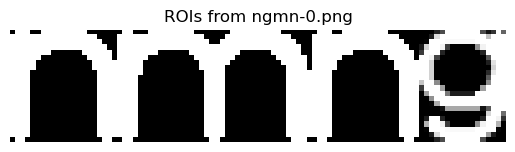

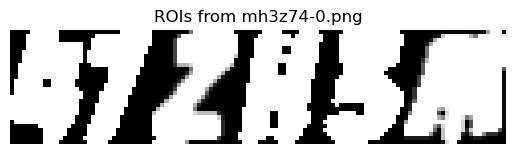

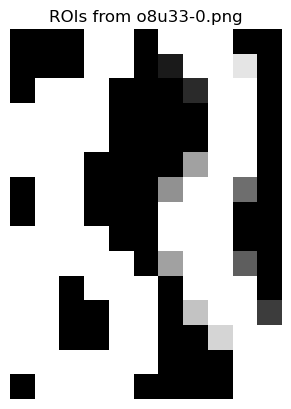

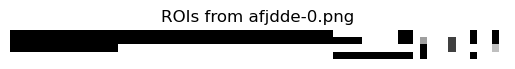

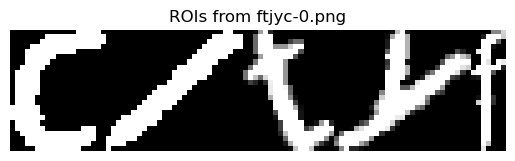

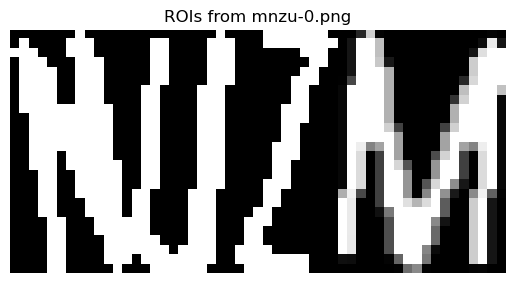

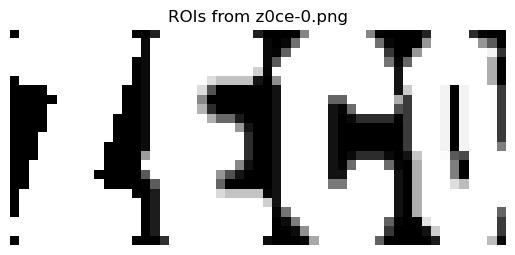

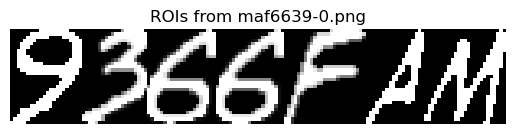

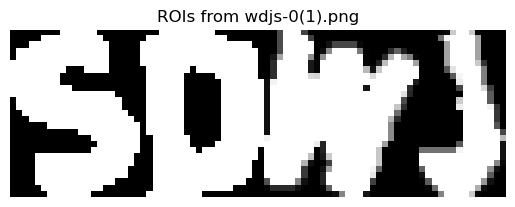

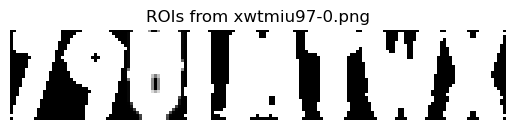

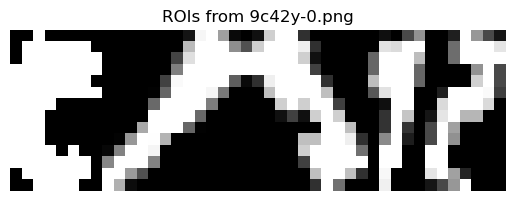

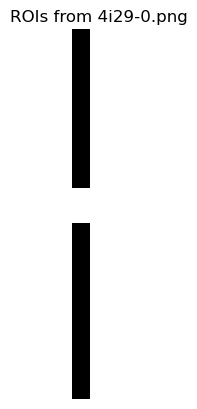

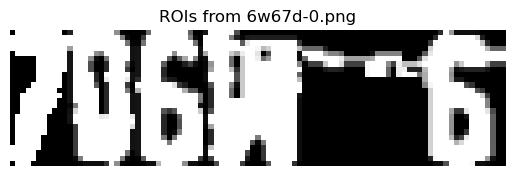

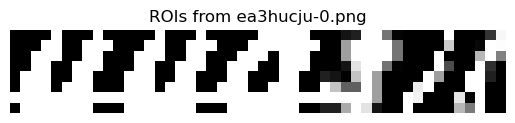

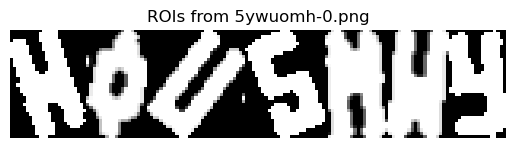

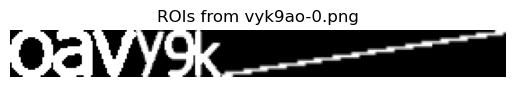

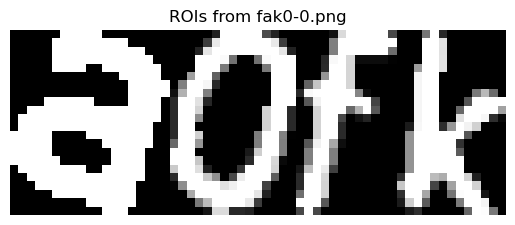

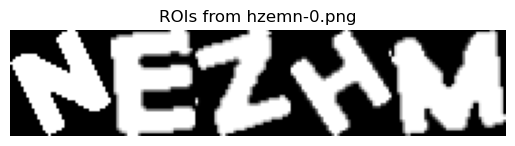

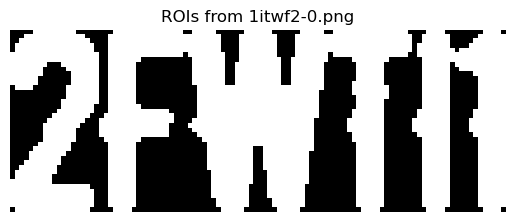

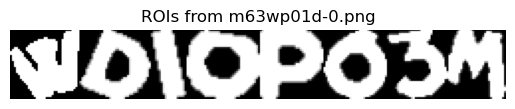

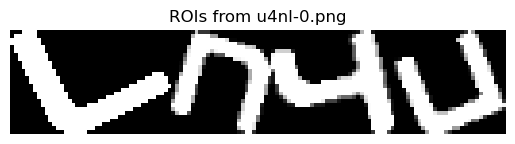

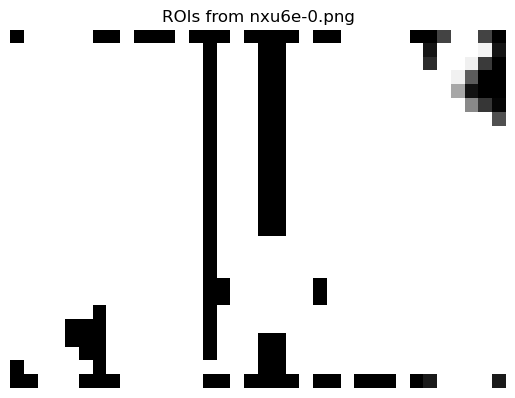

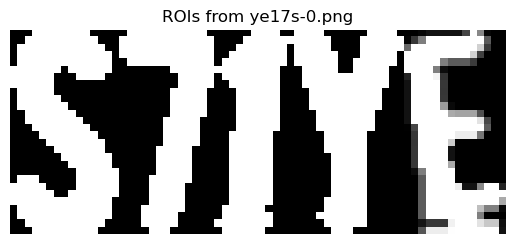

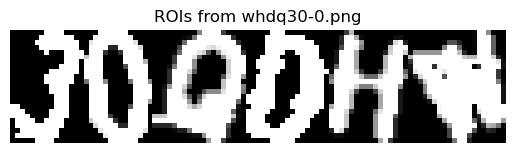

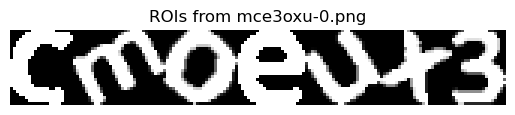

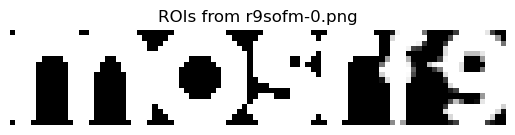

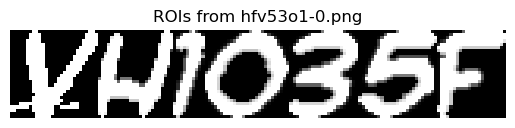

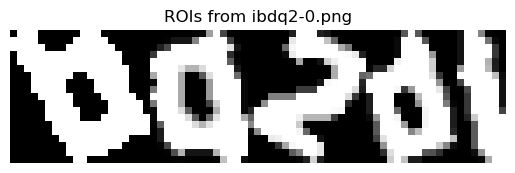

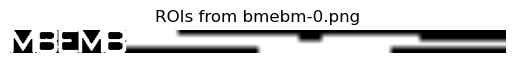

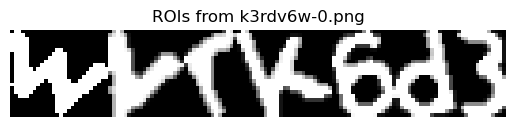

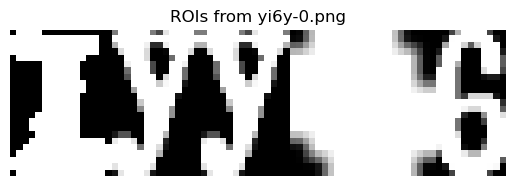

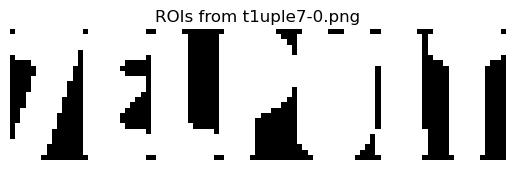

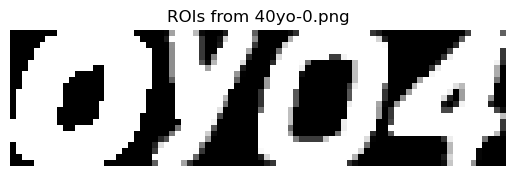

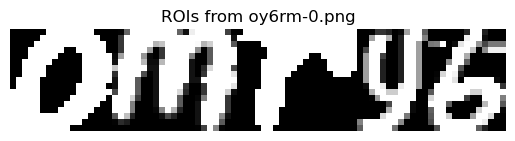

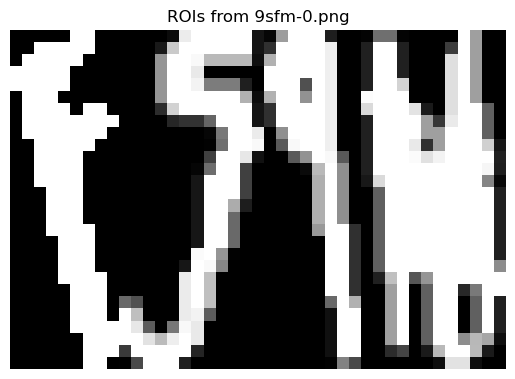

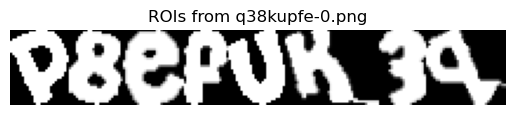

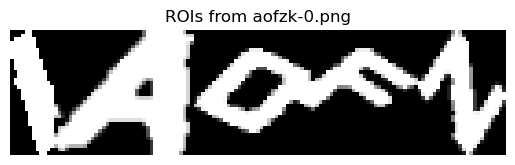

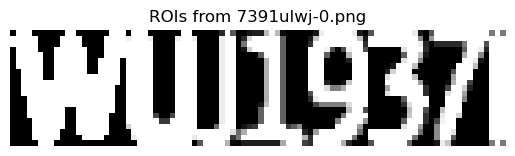

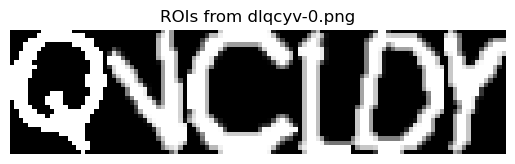

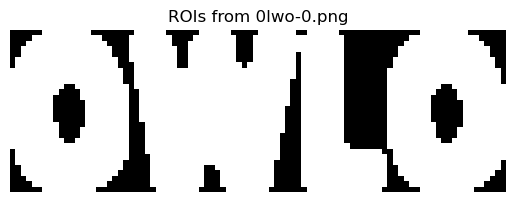

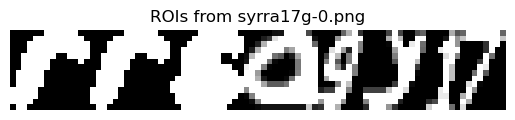

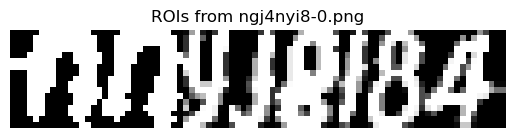

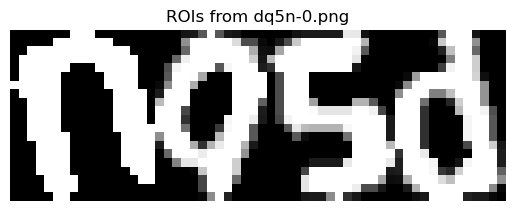

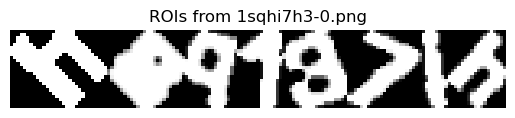

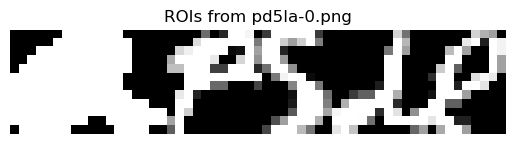

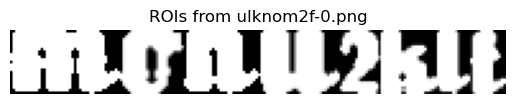

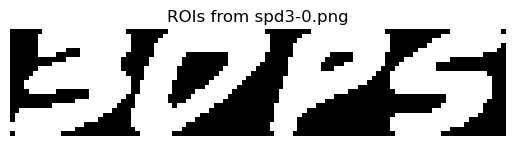

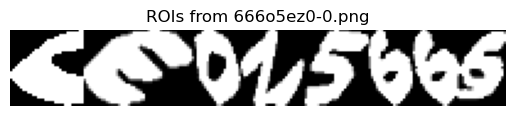

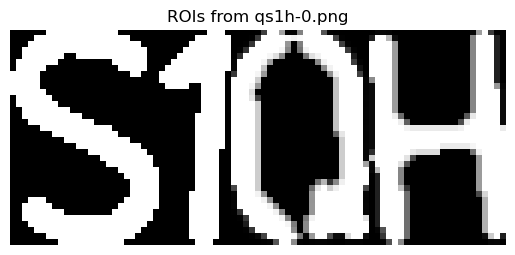

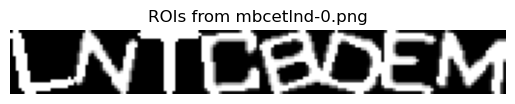

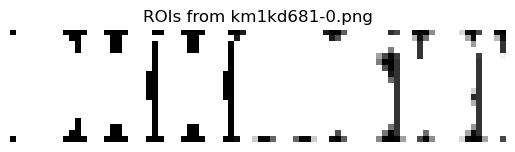

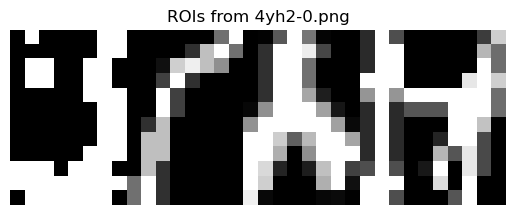

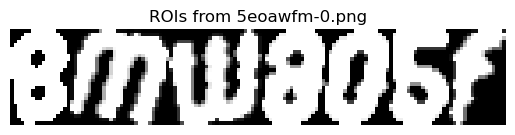

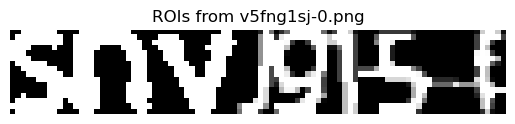

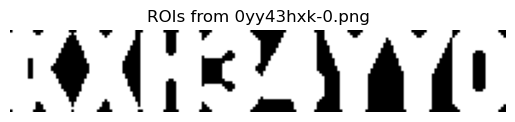

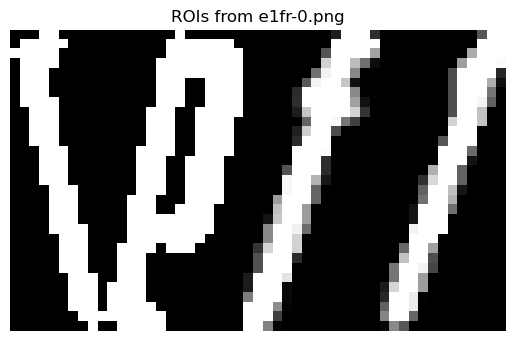

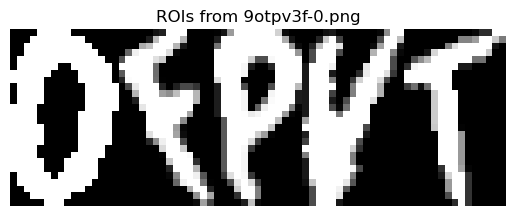

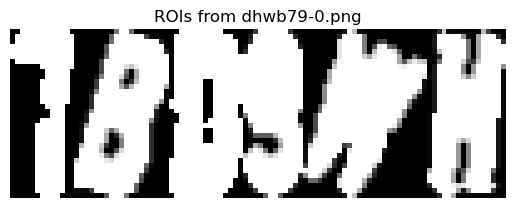

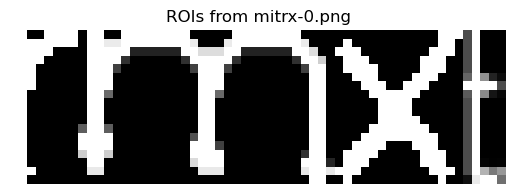

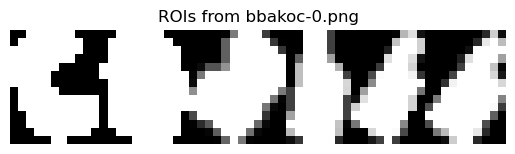

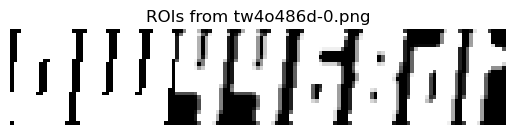

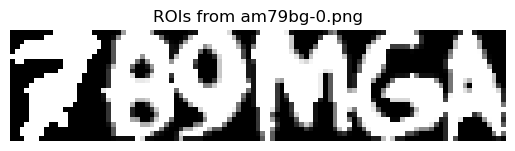

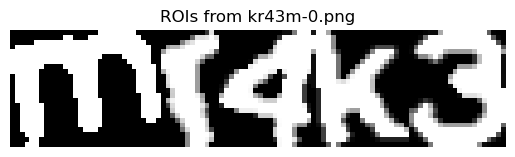

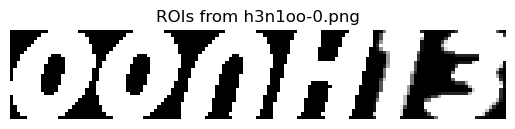

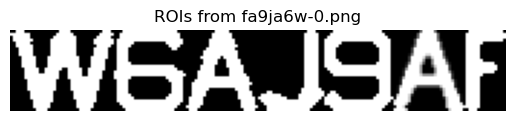

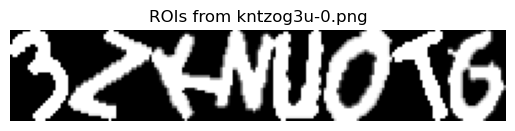

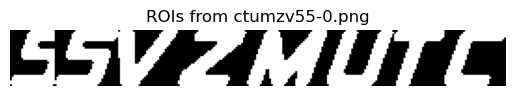

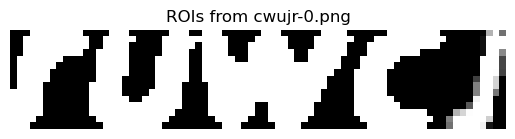

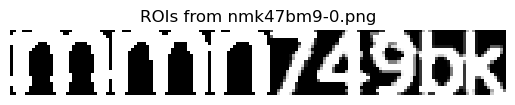

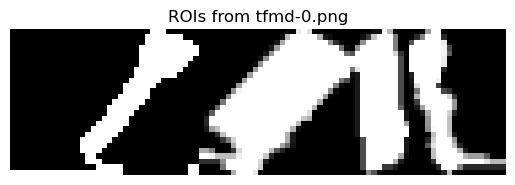

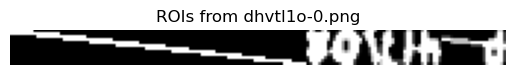

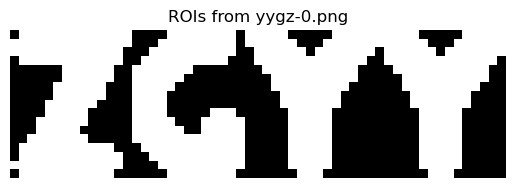

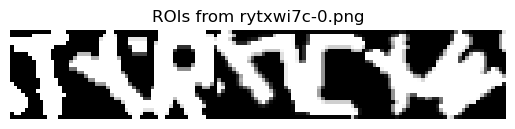

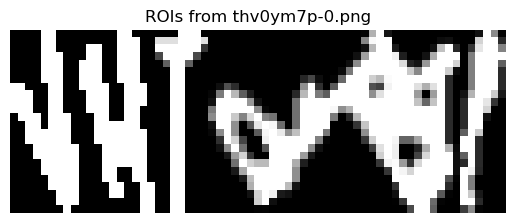

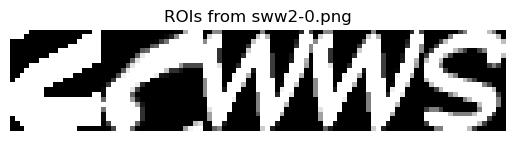

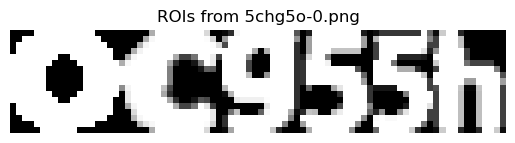

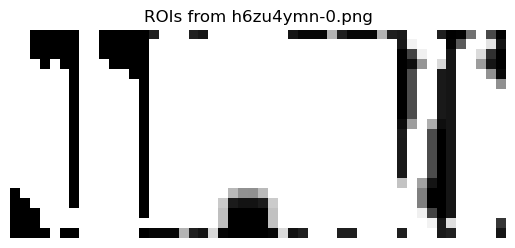

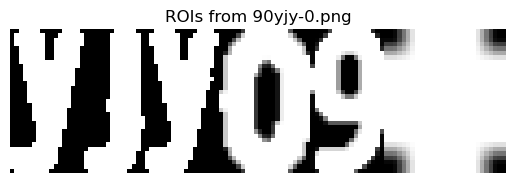

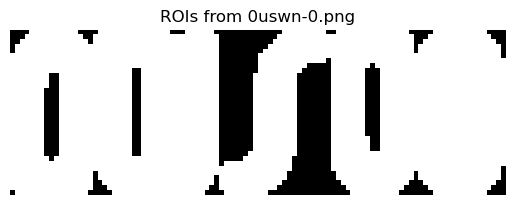

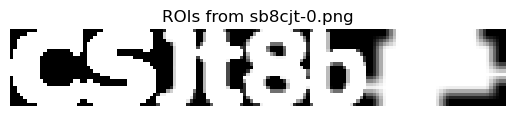

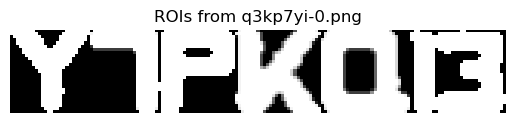

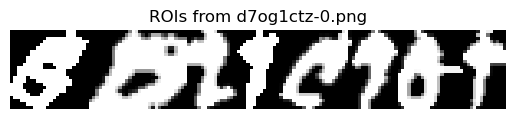

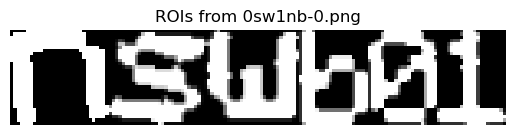

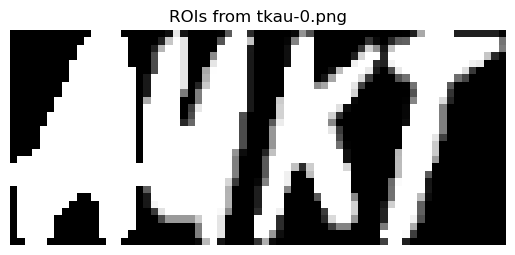

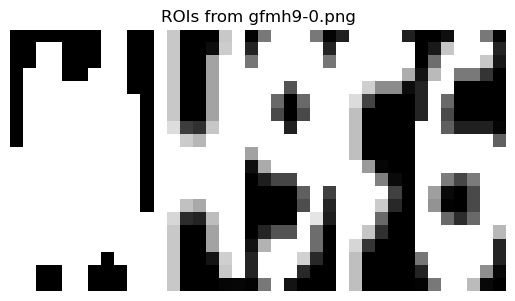

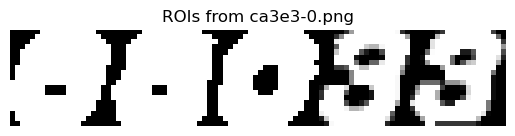

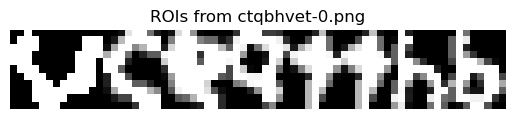

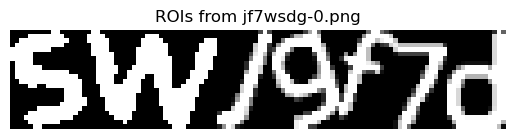

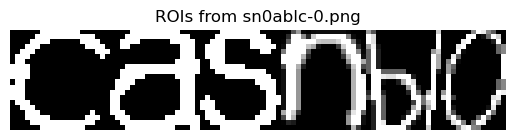

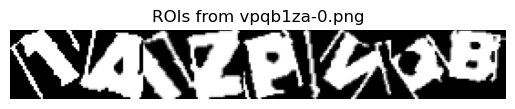

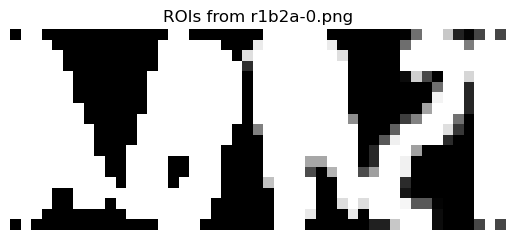

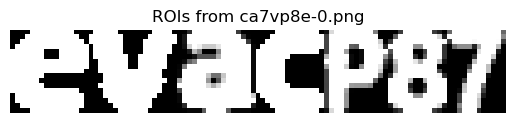

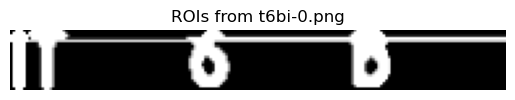

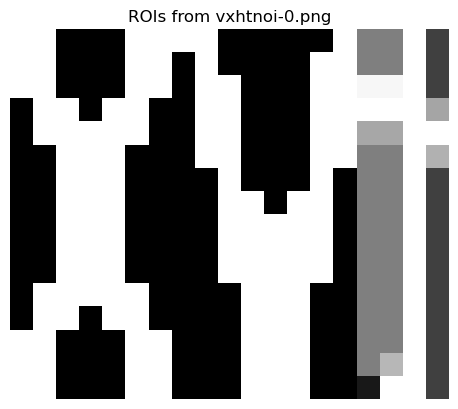

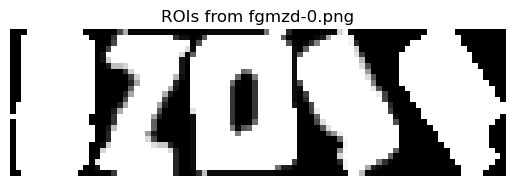

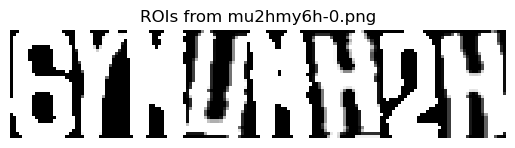

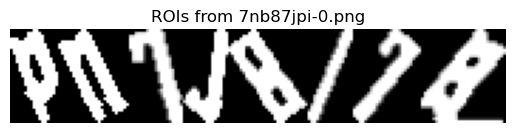

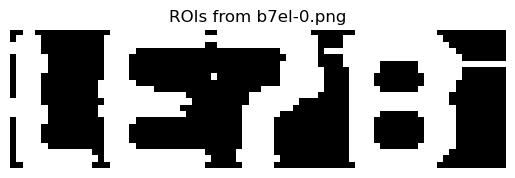

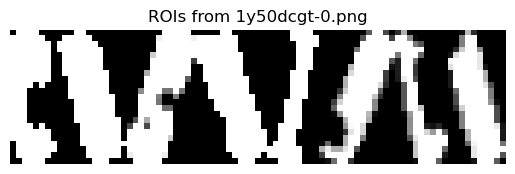

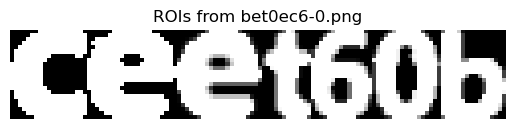

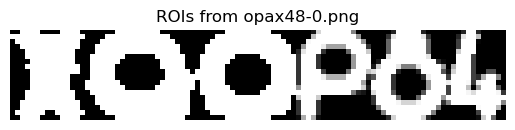

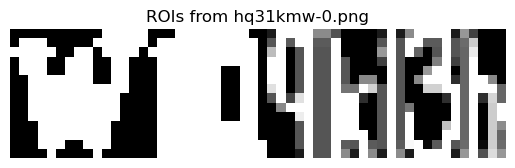

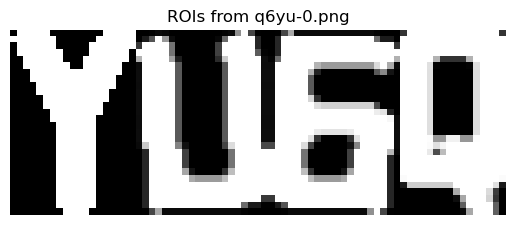

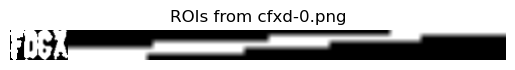

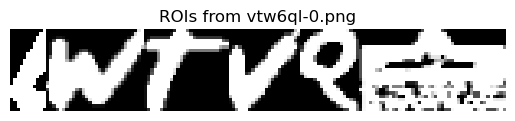

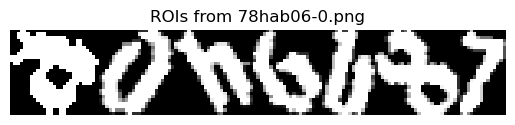

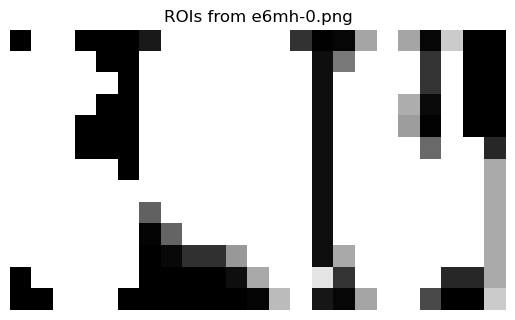

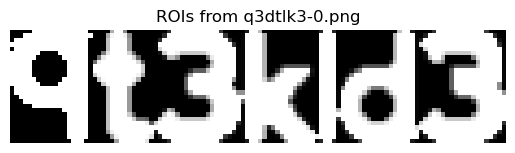

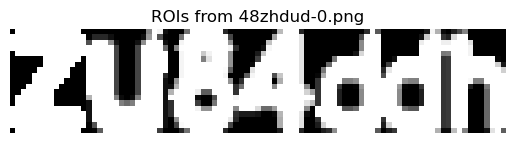

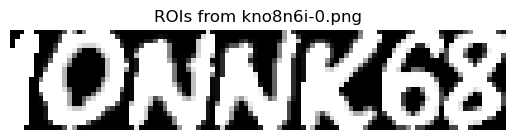

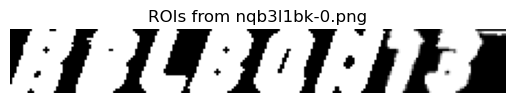

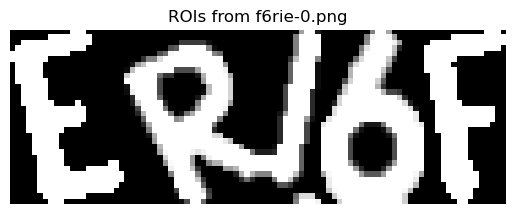

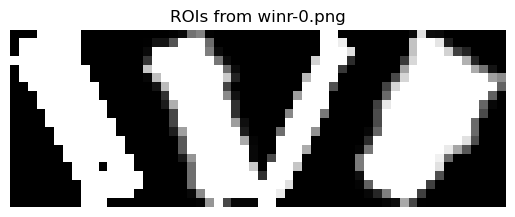

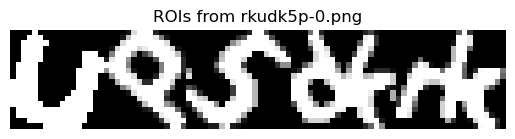

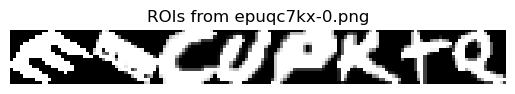

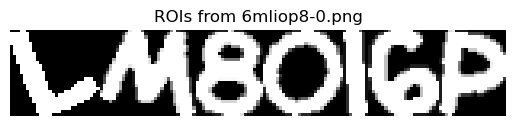

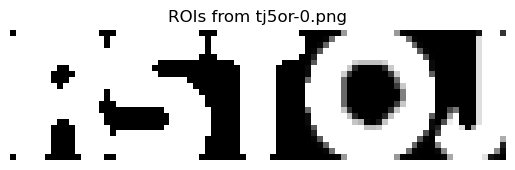

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

In [66]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

# Create output folder for segmented characters
input_folder = "train"
output_folder = "extracted_letter_images"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Get all image files in the train folder
image_files = [f for f in os.listdir(input_folder) if f.endswith(".png")]

# Iterate through each image file in the train folder
for image_file in image_files:
    image_path = os.path.join(input_folder, image_file)
    image = cv2.imread(image_path)
    
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)

    im_bw_inverted = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 15, 2)
    im_bw_inverted = cv2.medianBlur(im_bw_inverted, 3)

    # Adjust kernel size for closing operation
    kernel = np.ones((2, 2), np.uint8)
    closed = cv2.morphologyEx(im_bw_inverted, cv2.MORPH_CLOSE, kernel)
    
    
    
    # Perform closing operation
    

    # Find contours again after applying closing operation
    cnts = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    min_area = 20  # Lowered min area to capture smaller parts like dots
    min_width = float("inf")
    widths = []
    image_number = 0

    # Collect character widths
    for c in cnts:
        area = cv2.contourArea(c)
        if area > min_area:
            x, y, w, h = cv2.boundingRect(c)
            widths.append(w)

    mean = np.mean(widths)
    std_dev = np.std(widths)
    threshold = mean + std_dev 
    filtered_numbers = [num for num in widths if num <= threshold]

    average = np.max(filtered_numbers)

    # List to store ROIs for this image
    rois = []

    # Extract and save each character or segment
    for c in cnts:
        area = cv2.contourArea(c)
        x, y, w, h = cv2.boundingRect(c)

        if w > 1.5 * average and area > min_area:
            # Divide wide contour into smaller pieces of width ~ min_width
            num_segments = int(round(w / average))
            segment_width = w // num_segments

            for i in range(num_segments):
                x_segment = x + i * segment_width
                w_segment = segment_width if i < num_segments - 1 else (w - i * segment_width)
                ROI = closed[y:y+h, x_segment:x_segment + w_segment]
                rois.append(ROI)

                # Save the segmented character
                cv2.imwrite(os.path.join(output_folder, f"char_{image_number}.png"), ROI)
                image_number += 1

        elif area > min_area:
            # If contour width is close to min_width, save as is
            ROI = closed[y:y+h, x:x+w]
            rois.append(ROI)

            # Save the character image
            cv2.imwrite(os.path.join(output_folder, f"char_{image_number}.png"), ROI)
            image_number += 1

    # Ensure all ROIs have the same height
    if rois:
        # Get the target height (use the height of the first ROI or any other consistent height)
        target_height = rois[0].shape[0]

        # Resize all ROIs to the target height
        resized_rois = [cv2.resize(roi, (int(roi.shape[1] * target_height / roi.shape[0]), target_height)) for roi in rois]

        # Concatenate the resized ROIs horizontally
        concatenated_rois = np.hstack(resized_rois)

        # Display the concatenated ROIs
        plt.imshow(concatenated_rois, cmap='gray')
        plt.title(f"ROIs from {image_file}")
        plt.axis('off')  # Hide axes
        plt.show()
